 [-----------------100%-----------------] 50000 of 50000 complete in 3.4 sec

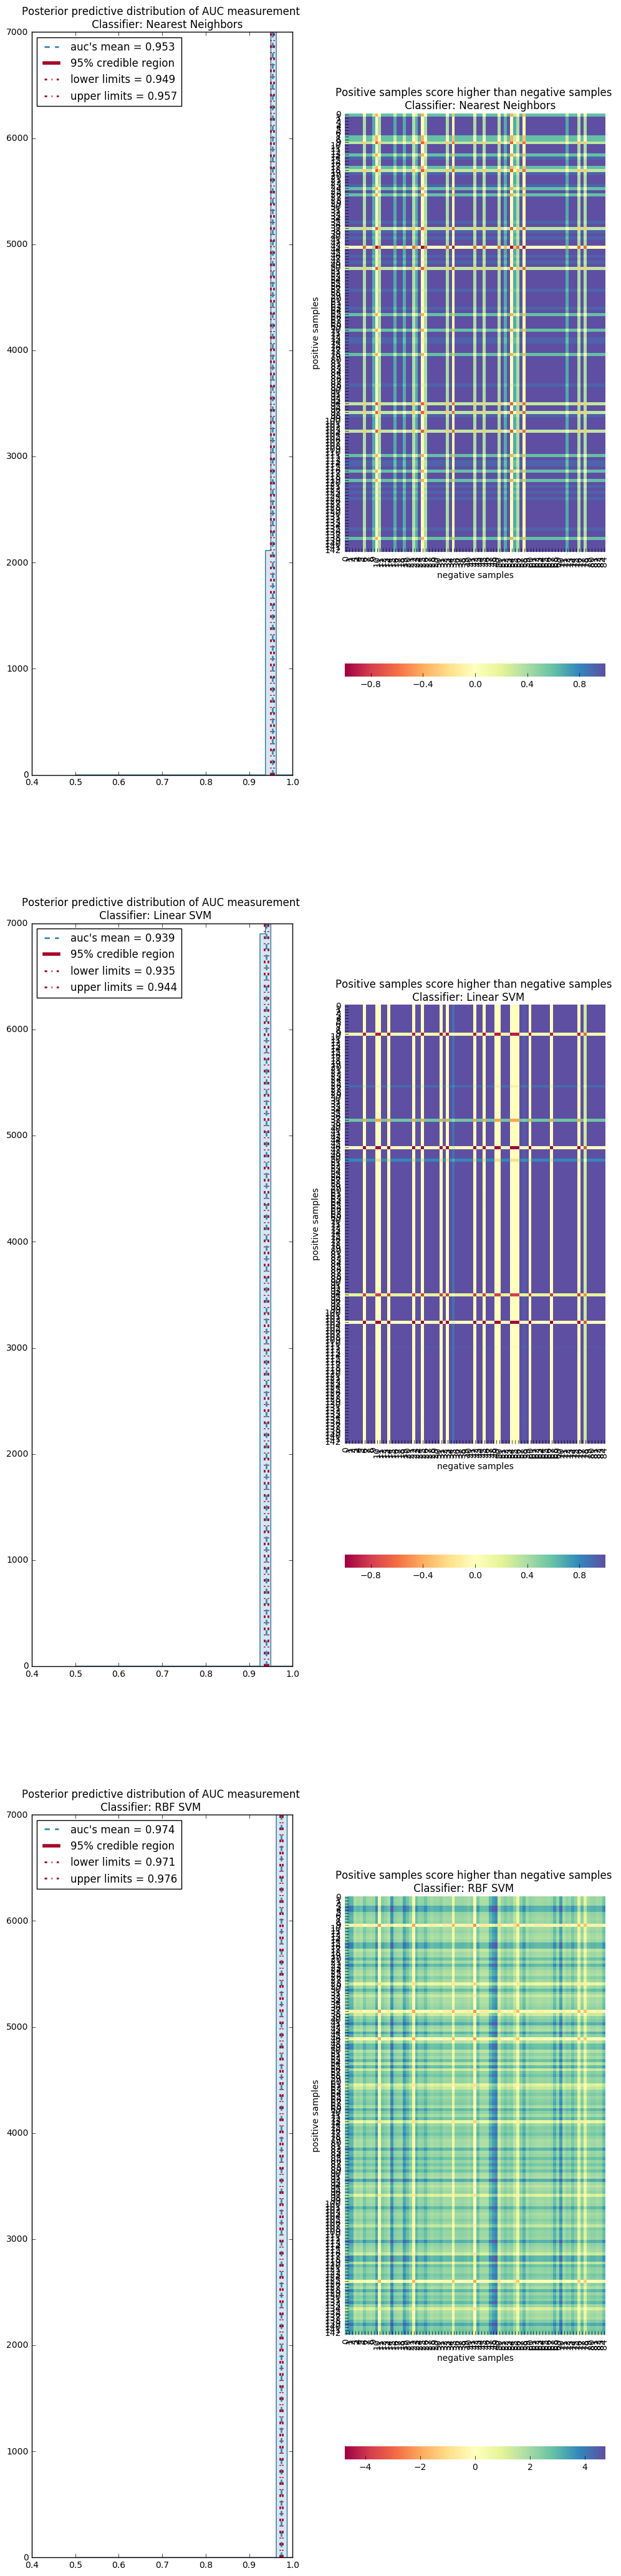

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import itertools
import pandas as pd
import seaborn.apionly as sns
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import rankdata
from sklearn.datasets import load_breast_cancer
%matplotlib inline

colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

names = ["Decision Tree", "Naive Bayes", "RBF SVM", "Nearest Neighbors", "Linear SVM",
         "Random Forest", "AdaBoost", "Linear Discriminant",
         "Quadratic Discriminant"]

# make table pretty
m = len(max(names, key=len))
for name,i in zip(names,range(len(names))):
    padding = ' '*(m-len(name))
    name =name + padding
    names[i]=name

classifiers = [
    DecisionTreeClassifier(min_samples_leaf = 0.08),
    MultinomialNB(alpha=0.0025),
    SVC(gamma=0.0001, C=12)]
#     KNeighborsClassifier(3),
#     SVC(kernel="linear"),
#     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     AdaBoostClassifier(),
#     LinearDiscriminantAnalysis(),
#     QuadraticDiscriminantAnalysis()]

summary = pd.DataFrame(columns=['F1_score','AUC_score','Mean','SD','95% HPD'], index=names)

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

# imbalanced dataset
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, weights=[0.9,0.1],
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
imbalanced = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable,imbalanced]

figure = plt.figure(figsize=(10, 45))
# X, y = datasets[1]
# X = StandardScaler().fit_transform(X)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)


X = load_breast_cancer().data
y = load_breast_cancer().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

i = 1
l = len(classifiers)
for name, clf in zip(names, classifiers):
    clf.fit(X_train,y_train)
    if hasattr(clf,"decision_function"):
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:,1]

    pos_score = y_score[y_test==1]
    neg_score = y_score[y_test==0]
    alldata = np.concatenate((pos_score , neg_score))
    ranked = rankdata(alldata)
    m1 = len(pos_score)
    m2 = len(neg_score)
    pos_rank = ranked[:m1]
    neg_rank = ranked[m1:]
    s = np.sum(pos_rank,axis=0)
    count = s - m1*(m1+1)/2.0

    # Binomal-Beta Conjugate
    n_sample = 50000
    burnin = 10000
    p = pm.Beta("p",alpha=1,beta=1)
    n = pm.Binomial("Bino",n=m1*m2,p=p,value=count,observed=True)
    mcmc = pm.MCMC([n,p])
    trace = mcmc.sample(n_sample)
    auc_trace = mcmc.trace("p")[burnin:]
    auc_mean = auc_trace.mean()
    std = auc_trace.std()

    # 95% credible region
    n_sample = auc_trace.shape[0]
    lower_limits = np.round(np.sort(auc_trace)[int(0.025 * n_sample)],decimals=3)
    upper_limits = np.round(np.sort(auc_trace)[int(0.975 * n_sample)],decimals=3)
    
    summary.ix[name,'F1_score'] = np.round(clf.score(X_test, y_test),decimals=4)
    summary.ix[name,'AUC_score'] =  np.round(roc_auc_score(y_test, y_score),decimals=4)
    summary.ix[name,'Mean'] = np.round(auc_mean,decimals=4)
    summary.ix[name,'SD'] = np.round(std,decimals=4)
    summary.ix[name,'95% HPD'] = (lower_limits,upper_limits)

    # plot Posterior predictive distribution of auc measure
    ax = plt.subplot(l,2,i)
    i += 1
    # from pymc.Matplot import plot as mcplot
    # mcplot(mcmc.trace("p"),common_scale=False)
    _ = ax.hist(auc_trace,range=[0.5, 1.0], bins=40, alpha=.9,
             histtype="step", color=colors[0], 
             label='')
    _hist = ax.hist(auc_trace,range=[0.5, 1.0], bins=40, alpha=.2,
             histtype="stepfilled", color=colors[0] )
    vlines_height = 1.2*np.max(_hist[0])
    _ = ax.vlines(auc_mean,  0.1, vlines_height, label="auc's mean = {0:0.3f}".format(auc_mean),
               linestyles="--", color=colors[0], linewidths=2)
    _ = ax.hlines(0.1, lower_limits, upper_limits, label="95% credible region",
             #  label="95% credible region = {0:0.3f}".format(upper_limits-lower_limits), 
               color=colors[1], linewidths=4)
    _ = ax.vlines(lower_limits,  0.1, vlines_height, label="lower limits = {0:0.3f}".format(lower_limits),
               linestyles="-.", color=colors[1], linewidths=2)
    _ = ax.vlines(upper_limits,  0.1, vlines_height, label="upper limits = {0:0.3f}".format(upper_limits),
               linestyles="-.", color=colors[1], linewidths=2)
    _ = ax.set_title("Posterior predictive distribution of AUC measurement \n \
        Classifier: {0} ".format(name))
    _ = ax.set_ylim([0,7000])
    _ = ax.legend(loc="upper left")

    # Create an empty dataframe
    df = pd.DataFrame(index=range(m1), columns=range(m2), dtype=np.float)

    def prob_score_higher(s_a, s_b):
        return (s_a - s_b)
#         if (s_a - s_b)>0:
#             return 1
#         elif(s_a - s_b)==0:
#             return 0.5
#         else:
#             return 0


    # populate each cell in dataframe with persona_less_personb()
    for a, b in itertools.product(range(m1), range(m2)):
        df.ix[a, b] = prob_score_higher(pos_score[a],neg_score[b])

    ax = plt.subplot(l,2,i)
    i += 1
    cmap = plt.get_cmap("Spectral")
    _ = sns.heatmap(df, square=True,cmap=cmap,cbar_kws={"orientation": "horizontal"})
    _ = ax.set_title("Positive samples score higher than negative samples \n \
        Classifier: {0} ".format(name))
    _ = ax.set_ylabel("positive samples")
    _ = ax.set_xlabel("negative samples")

figure.subplots_adjust(left=.04, right=.96, bottom=.05, top=.95)
plt.show()

In [13]:
summary

,F1_score,AUC_score,Mean,SD,95% HPD
Nearest Neighbors,0.8947,0.9532,0.9532,0.0019,"(0.949, 0.957)"
Linear SVM,0.8991,0.9396,0.9395,0.0022,"(0.935, 0.944)"
RBF SVM,0.943,0.9738,0.9737,0.0015,"(0.971, 0.976)"
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
AdaBoost,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Linear Discriminant,NaN,NaN,NaN,NaN,NaN
Quadratic Discriminant,NaN,NaN,NaN,NaN,NaN


In [120]:
summary.to_csv('../result/ds4.txt',sep='\t', encoding='utf-8')
summary.to_csv('../result/ds4.txt',sep='\t', encoding='utf-8')
summary.to_html('../result/ds4.html')
summary.to_excel('../result/ds4.xls')
# rnk = summary.rank(ascending=False)
# with open('../result/ds3.csv', 'a') as f:
#     rnk.to_csv(f,sep='\t', encoding='utf-8')

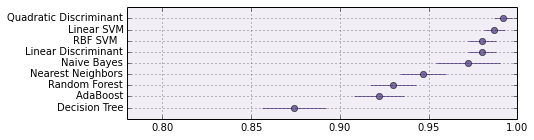

In [129]:
order = np.argsort(-np.array(summary['Mean']))  #排序后的数据原来位置的下标；负号表示降序
summary['Mean'][order]
ordered_names = []
for i in order:
    ordered_names.append(names[i])
    
figure = plt.figure(figsize=(7,2))
ax = plt.subplot()
r_order=order[::-1] #reversed order
_ = ax.errorbar(summary['Mean'][r_order], np.arange(len(order)),
             xerr=summary['SD'][r_order], xuplims=True, capsize=0, fmt='o',
             color='#7A68A6')

_ = ax.set_xlim(0.78, 1)
_ = ax.set_ylim(-1,9)
_ = plt.yticks(np.arange(len(order)-1,-1,step= -1),
                  map(lambda x: x.replace("\n", ""), ordered_names))
_ = ax.grid(True)
ax.patch.set_facecolor('#7A68A6')
ax.patch.set_alpha(0.1)

 [-----------------100%-----------------] 20000 of 20000 complete in 1.7 sec

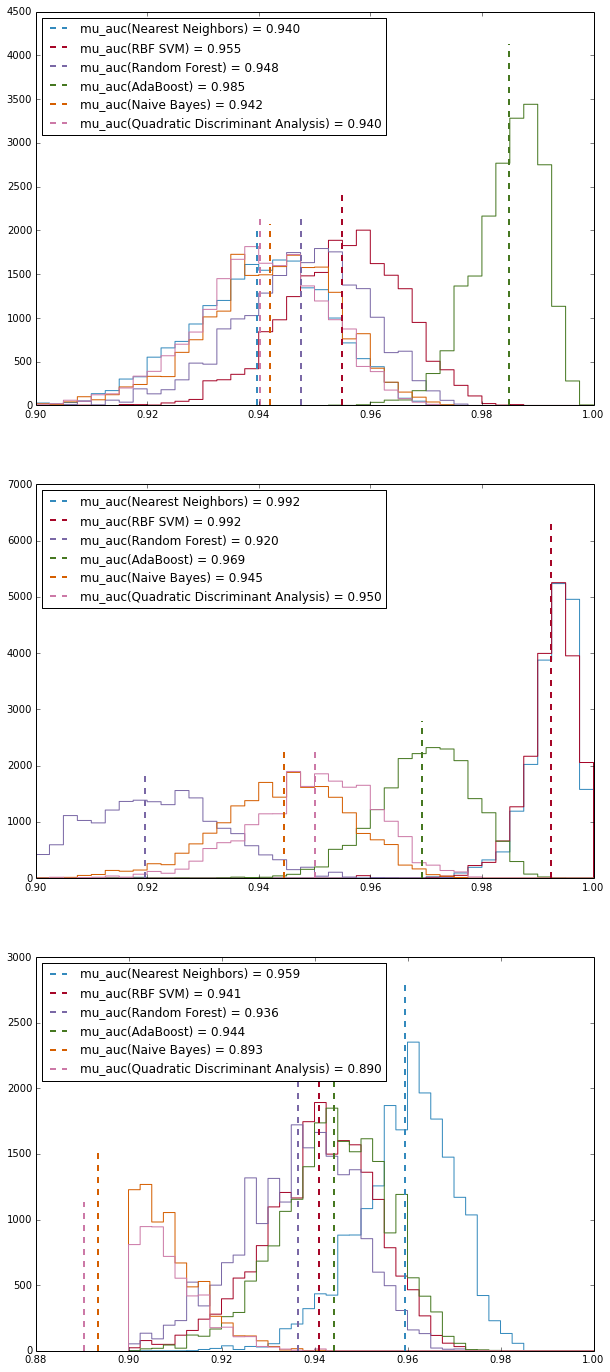

In [252]:
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

names = ["Nearest Neighbors", "RBF SVM", 
         "Random Forest", "AdaBoost", "Naive Bayes", 
         "Quadratic Discriminant Analysis"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(gamma=2, C=1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

ii = 1
figure = plt.figure(figsize=(10, 24))
for ds in datasets:
    ax = plt.subplot(3,1,ii)
    ii += 1
    X, y = datasets[0]
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    i = 0
    l = len(classifiers)
    for name, clf in zip(names, classifiers):
        clf.fit(X_train,y_train)
        if hasattr(clf,"decision_function"):
            y_score = clf.decision_function(X_test)
        else:
            y_score = clf.predict_proba(X_test)[:,1]
        roc_score = roc_auc_score(y_test, y_score)

        pos_score = y_score[y_test==1]
        neg_score = y_score[y_test==0]
        # ranksums(pos_score, neg_score)
        alldata = np.concatenate((pos_score , neg_score))
        ranked = rankdata(alldata)
        m1 = len(pos_score)
        m2 = len(neg_score)
        pos_rank = ranked[:m1]
        neg_rank = ranked[m1:]
        s = np.sum(pos_rank,axis=0)
        count = s - m1*(m1+1)/2.0

        # Binomal-Beta Conjugate
        n_sample = 20000
        p = pm.Beta("p",alpha=1,beta=1)
        n = pm.Binomial("Bino",n=m1*m2,p=p,value=count,observed=True)
        mcmc = pm.MCMC([n,p])
        trace = mcmc.sample(n_sample)
        auc_trace = mcmc.trace("p")[:]
        auc_mean = auc_trace.mean()

        # 95% credible region
        n_sample = auc_trace.shape[0]
        lower_limits = np.sort(auc_trace)[int(0.025 * n_sample)]
        upper_limits = np.sort(auc_trace)[int(0.975 * n_sample)]

        # plot Posterior predictive distribution of auc measure
        _hist  = ax.hist(auc_trace,range=[0.9, 1.0], bins=40, 
                 histtype="step", color=colors[i], 
                 label='')
        #     _hist = ax.hist(auc_trace,range=[0.9, 1.0], bins=40, alpha=.2,
        #              histtype="stepfilled", color=colors[i] )
        vlines_height = 1.2*np.max(_hist[0])
        _ = ax.vlines(auc_mean,  0.1, vlines_height, label="mu_auc({0}) = {1:0.3f}".format(names[i],auc_mean),
                   linestyles="--", color=colors[i], linewidths=2)
        _ = ax.legend(loc="upper left")
        i +=1

plt.show()

In [ ]:
# another way (randomly)
import random
count = 0
sample = 300
for i in range(sample):
    pos_r = random.choice(pos_rank)
    neg_r = random.choice(neg_rank)
    if pos_r > neg_r:
        count += 1
    elif pos_r == neg_r:
        count += 0.5
    else:
        pass
    
p = pm.Beta("auc",alpha=1,beta=1)
n = pm.Binomial("Bino",n=sample,p=p,value=count,observed=True)
mcmc = pm.MCMC([n,p])
mcmc.sample(25000)

%matplotlib inline
from pymc.Matplot import plot as mcplot
mcplot(mcmc.trace("auc"),common_scale=False)

In [306]:
X, y = datasets[0]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

clf = classifiers[2]
clf.fit(X_train,y_train)
if hasattr(clf,"decision_function"):
    y_score = clf.decision_function(X_test)
else:
    y_score = clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, y_score)

pos_score = y_score[y_test==1]
neg_score = y_score[y_test==0]

# sort in increasing order
pos_score = np.sort(pos_score)
neg_score = np.sort(neg_score)

alldata = np.concatenate((pos_score , neg_score))
ranked = rankdata(alldata)
m1 = len(pos_score)
m2 = len(neg_score)
pos_rank = ranked[:m1]
neg_rank = ranked[m1:]

In [326]:
n = 1000
mu = np.ones(m1)/m1
fr = pm.Multinomial('n', n=1000, p=mu)
# fr = np.ones(m1)

def x(rank,fr):
    a = np.sum([ (rank[i]-1)*fr[i] for i in range(m1) ])
    b = np.sum([ (m1-(i+1)) for i in range(m1) ])
    return (a-b)

x(pos_rank,fr.random())
# s = np.sum(pos_rank,axis=0)
# s - m1*(m1+1)/2.0


26772.5

 [-----------------100%-----------------] 1000 of 1000 complete in 60.7 secPlotting x
Plotting p


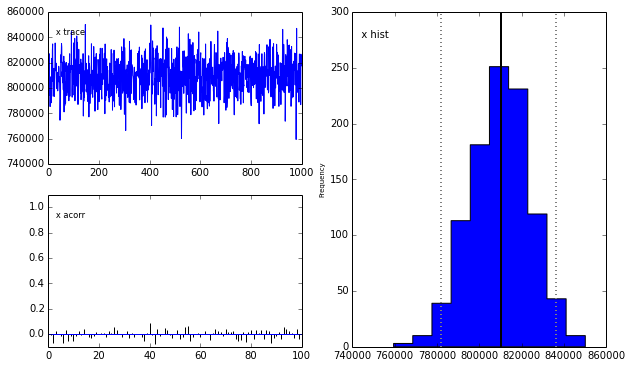

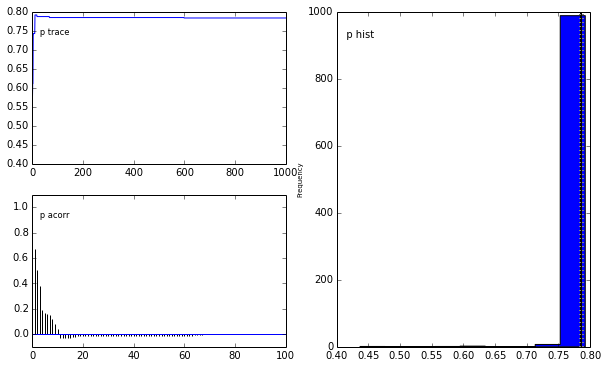

In [343]:
n_sample = 1000
mu1 = np.ones(m1)/m1
mu2 = np.ones(m2)/m2
fr1 = pm.Multinomial('fr1', n=n_sample, p=mu1)
fr2 = pm.Multinomial('fr2', n=n_sample, p=mu2)

dist_df = pd.DataFrame(index=range(m1), columns=range(m2), dtype=np.double)

def is_score_higher(pos_r, neg_r):       
    if pos_r > neg_r:
        return 1.0
    elif pos_r == neg_r:
        return 0.5
    else:
        return -1.0

@pm.deterministic
def x(fr1=fr1,fr2=fr2,m1=m1,m2=m2):
    for a, b in itertools.product(range(m1), range(m2)):
        dist_df.ix[a, b] = is_score_higher(pos_score[a],neg_score[b])*fr1[a]*fr2[b]
    return dist_df.sum().sum()

p = pm.Beta("p",alpha=1,beta=1)
n = pm.Binomial("Bino",n=n_sample*n_sample,p=p,value=x,observed=True)

mcmc = pm.MCMC([x,fr1,fr2,mu1,mu2,n,p])
mcmc.sample(n_sample)

from pymc.Matplot import plot as mcplot
mcplot(mcmc.trace(x),common_scale=False)
mcplot(mcmc.trace("p"),common_scale=False)

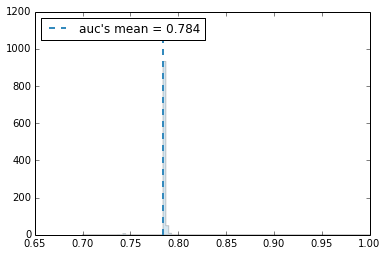

In [354]:
auc_trace = mcmc.trace("p")[:]
auc_mean = auc_trace.mean()

# 95% credible region
n_sample = auc_trace.shape[0]
lower_limits = np.sort(auc_trace)[int(0.025 * n_sample)]
upper_limits = np.sort(auc_trace)[int(0.975 * n_sample)]

ax = plt.subplot()
_hist = ax.hist(auc_trace,range=[0.7, 1.0], bins=100, alpha=.2,
         histtype="stepfilled", color=colors[0] )
vlines_height = 1.2*np.max(_hist[0])
_ = ax.vlines(auc_mean,  0.1, vlines_height, label="auc's mean = {0:0.3f}".format(auc_mean),
           linestyles="--", color=colors[0], linewidths=2)
_ = ax.legend(loc="upper left")
plt.show()


In [359]:
dist_df = pd.DataFrame(index=range(m1), columns=range(m2), dtype=np.double)

n_sample = 1000
mu1 = np.ones(m1)/m1
mu2 = np.ones(m2)/m2
fr1 = pm.Multinomial('fr1', n=n_sample, p=mu1)
fr2 = pm.Multinomial('fr2', n=n_sample, p=mu2)

def is_score_higher(pos_r, neg_r):       
    if pos_r > neg_r:
        return 1.0
    elif pos_r == neg_r:
        return 0.5
    else:
        return -1.0


for a, b in itertools.product(range(m1), range(m2)):
    dist_df.ix[a, b] = is_score_higher(pos_score[a],neg_score[b])*fr1.random()[a]*fr2.random()[b]

dist_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3190,2450,2250,2400,1560,2940,1890,1247,1696,-2392,-2116,-2592,-2750,-2508,-1800,-3402,-2508,-2438,-3564.0
1,2700,2296,2009,2400,2392,2680,1845,2484,2310,2548,2601,2652,2538,2695,-2915,-2832,-1890,-1935,-2352.0
2,2867,2499,2436,3479,3245,2430,2160,3584,2850,2420,2880,2585,2596,1720,-1892,-1974,-2501,-2430,-3111.0
3,3416,3534,2548,1568,2880,2580,2091,3360,3538,2254,2450,2809,2700,2021,-2548,-3422,-3366,-2623,-2850.0
4,2150,2295,2444,2760,3074,1739,2752,2491,1936,2726,2744,2392,2754,3808,2448,2520,3120,2280,-2385.0
5,3477,2332,3149,2236,2128,2295,1776,1886,2499,2632,2475,3111,2475,2499,2646,2024,2236,2968,-2200.0
6,4026,2204,3009,2596,2475,3782,2064,2430,1952,2750,2205,2457,2964,1584,2700,1836,2900,2160,-3135.0
7,3420,2340,2916,3392,2208,2420,2352,3060,2450,2655,2704,2100,2275,2907,2385,2016,3250,1932,-1848.0
8,1769,2600,2254,2968,1925,2576,3025,2450,2279,2944,2170,1716,2650,1551,2240,1833,2491,3072,-3600.0
9,2576,2385,2021,2254,2754,3519,2052,2184,2376,1628,1768,2296,2700,3078,2322,1806,2280,2112,-2303.0
